# Introduction

Blood cancer diagnosis relies heavily on the microscopic analysis of blood smears, where the identification of abnormal cell morphology plays a critical role in early detection and treatment planning. This Jupyter notebook explores the development of an automated classification system for blood cell images, leveraging machine learning techniques to distinguish between key cell types associated with hematological malignancies.

Our dataset includes examples of all five cell types across disease stages, enabling models to learn both healthy and pathological morphologies. This allows detection of abnormal cells even in mixed populations—mirroring real clinical workflows where smears contain both normal and cancerous cells.

# Importations

In [3]:
# Basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os

# Iteration Tools
import itertools

# Warning Ignorance for Redundant Warnings
import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing and Verification Modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# TensorFlow
import tensorflow as tf

# Data Extraction
import kagglehub
from pathlib import Path
from PIL import Image

# HOG tools
from skimage.feature import hog
from skimage import exposure

# Classical ML Models and Tools
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB

# Neural Network Models and Tools
from tensorflow.data import AUTOTUNE
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, SGD
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data.experimental import cardinality
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential as SequentialLayer
from tensorflow.keras import Input

In [4]:
# Download latest version
data_dir = kagglehub.dataset_download("sumithsingh/blood-cell-images-for-cancer-detection")

# Make data_dir into a Path so that '/' can be used on it

data_dir = Path(data_dir)

print("Path to dataset files:", data_dir)

# Set classes
CLASSES = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

Path to dataset files: /root/.cache/kagglehub/datasets/sumithsingh/blood-cell-images-for-cancer-detection/versions/2


In [5]:
# Create a function that can pull the first file from each class (folder) and display it

def show_sample_image(data_dir, CLASSES):

    base_dir = data_dir
    classes = CLASSES

    plt.figure(figsize=(15, 3))

    for idx, class_name in enumerate(classes, 1):
        try:
            class_dir = base_dir / class_name
            first_file = next(class_dir.glob('*.jpg'))

            img = Image.open(first_file)
            plt.subplot(1, 5, idx)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')

        except StopIteration:
            print(f"No images found in {class_name}")
        except Exception as e:
            print(f"Error with {class_name}: {e}")

    plt.tight_layout()
    plt.show()

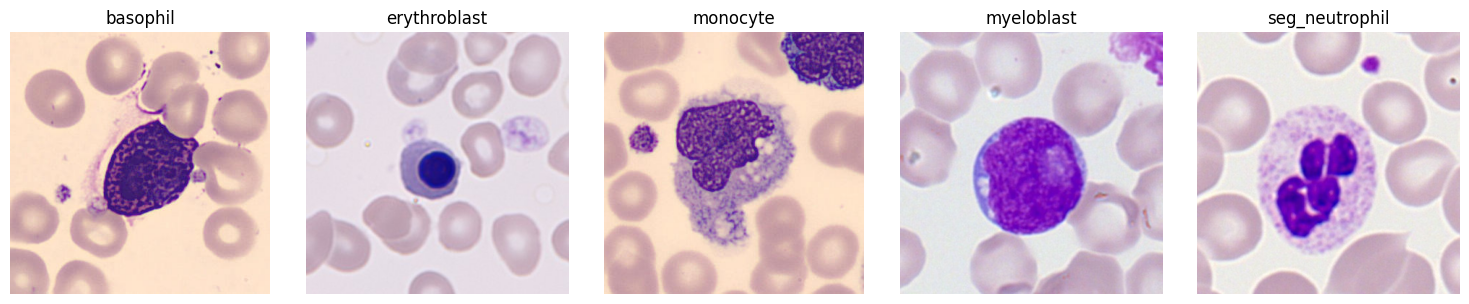

In [6]:
show_sample_image(data_dir, CLASSES)

This dataset features five different cells (definitions from Kaggle dataset):

*   Basophil: Granulocytes with dark-staining granules that often obscure the nucleus.
*   Erythroblast: Immature red blood cells with round nuclei.
*   Monocyte: Large white blood cells with distinctive kidney-shaped nuclei.
*   Myeloblast: Immature white blood cells that normally develop into granulocytes.
*   Segmented Neutrophils: Mature white blood cells with multi-lobed nuclei.




#Preprocessing Functions and Testing

A valuable and powerful technique used in preprocessing of image data, specifically for object detection is called Histogram of Oriented Gradients (HOG). It aims to capture localized regions of an image, which can be used to describe the shape or structure of an object within that image.

This can be helpful for our dataset because cells can possess very small variations in positioning, size, or orientation, but HOG's ability to capture local gradients will allow it to remain robust and identify the necessary minute differences.

Additionally, HOG will help us reduce dimensionality of complex images and focus on key features of it. This will also allow us to utilize HOG features and run them through classical machine learning classifiers (SVM, Random Forest, decsion tree, etc.) Which is what we will do in the next few sections.

In [5]:
# First we need to load and preprocess the image using a function

def load_and_preprocess_image(image_path, target_size=(200, 200)):
    # Read the image and convert to grayscale
    image = cv2.imread(image_path)

    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the image to a consistent size (optional)
    resized_image = cv2.resize(grayscale_image, target_size)

    return resized_image

# Function to extract HOG features using skimage

def extract_hog_features(image):

    features, hog_image = hog(image, block_norm='L2-Hys', visualize=True)

    return features, hog_image

In [6]:
image_path = os.path.join(data_dir, 'seg_neutrophil', 'NGS_2626.jpg')
processed_image = load_and_preprocess_image(image_path)

features, hog_image = extract_hog_features(processed_image)

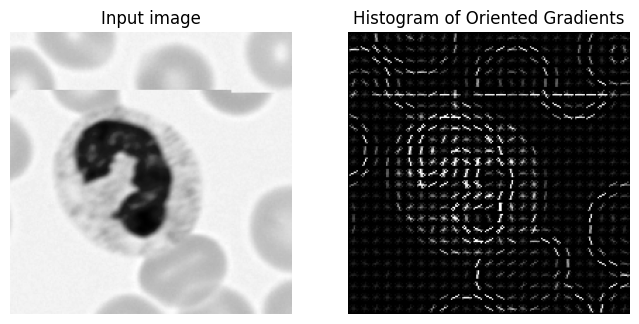

In [7]:
# Plot the input image and the HOG image for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(processed_image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [8]:
# Check the dimensions of the processed image and the length of the HOG feature vector
print(processed_image.shape)
print(len(features))

(200, 200)
42849


In [9]:
# Create a list of subdirectories and corresponding labels for the purpose of creating a tabular dataset
subdirectories = [os.path.join(data_dir, d) for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
class_labels = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
display(subdirectories)
display(CLASSES)

['/root/.cache/kagglehub/datasets/sumithsingh/blood-cell-images-for-cancer-detection/versions/2/monocyte',
 '/root/.cache/kagglehub/datasets/sumithsingh/blood-cell-images-for-cancer-detection/versions/2/basophil',
 '/root/.cache/kagglehub/datasets/sumithsingh/blood-cell-images-for-cancer-detection/versions/2/seg_neutrophil',
 '/root/.cache/kagglehub/datasets/sumithsingh/blood-cell-images-for-cancer-detection/versions/2/myeloblast',
 '/root/.cache/kagglehub/datasets/sumithsingh/blood-cell-images-for-cancer-detection/versions/2/erythroblast']

['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

In [10]:
def create_hog_feature_dataset(subdirectories, class_labels, output_file='hog_feature_dataset.csv', r_height=200, r_width=200, orientations=8, ppc=(10, 10)):
    """
    Creates a dataset of HOG features for images in subdirectories and saves it as a CSV file.

    Args:
    - subdirectories (list): List of subdirectory paths containing images.
    - class_labels (list): List of class labels corresponding to each subdirectory.
    - output_file (str): The name of the CSV file to save the dataset.
    - r_height (int): The target height for resizing images.
    - r_width (int): The target width for resizing images.
    - orientations (int): Number of gradient orientation bins for HOG.
    - ppc (tuple): Pixels per cell for HOG feature extraction (height, width).

    Returns:
    - pd.DataFrame: A dataframe containing the HOG features and labels.
    """
    try:
        # Try to load the pre-existing dataset if available
        hog_feature_dataset = pd.read_csv(output_file)
        print(f"Dataset loaded from {output_file}")
    except FileNotFoundError:
        # If the dataset does not exist, process images and create the dataset
        print(f"Creating dataset and saving to {output_file}...")

        # Lists to store features and corresponding labels
        X = []
        y = []

        # Loop through subdirectories and process each image
        for n, subdir in enumerate(subdirectories):
            image_paths = os.listdir(subdir)
            label = class_labels[n]

            for image_name in image_paths:
                image_path = os.path.join(subdir, image_name)
                image = load_and_preprocess_image(image_path, target_size=(200, 200))

                # Extract HOG features
                features, hog_image = hog(image, block_norm='L2-Hys', visualize=True)

                # Append the features and label to the lists
                X.append(features)
                y.append(label)

        # Convert to numpy arrays
        X = np.array(X)
        y = np.array(y)

        # Convert to dataframe and export to CSV
        hog_feature_dataset = pd.DataFrame(X)
        hog_feature_dataset['label'] = pd.Series(y)

        # Save the dataframe to CSV
        hog_feature_dataset.to_csv(output_file, index=False)
        print(f"Dataset saved to {output_file}")

    return hog_feature_dataset

In [11]:
# Now let's create the dataset

# Define the subdirectories (list of paths to directories with images)
subdirectories = ['/root/.cache/kagglehub/datasets/sumithsingh/blood-cell-images-for-cancer-detection/versions/2/seg_neutrophil',
 '/root/.cache/kagglehub/datasets/sumithsingh/blood-cell-images-for-cancer-detection/versions/2/myeloblast',
 '/root/.cache/kagglehub/datasets/sumithsingh/blood-cell-images-for-cancer-detection/versions/2/basophil',
 '/root/.cache/kagglehub/datasets/sumithsingh/blood-cell-images-for-cancer-detection/versions/2/monocyte',
 '/root/.cache/kagglehub/datasets/sumithsingh/blood-cell-images-for-cancer-detection/versions/2/erythroblast']
class_labels = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

# Create HOG feature dataset (if not already created)
hog_feature_dataset = create_hog_feature_dataset(subdirectories, class_labels)

# Save it to a csv file since it takes a few minutes to run each time
hog_feature_dataset.to_csv('hog_feature_dataset.csv', index=False)

# # We can just read the csv file now that it's saved locally

# hog_feature_dataset = pd.read_csv('hog_feature_dataset.csv')

Creating dataset and saving to hog_feature_dataset.csv...
Dataset saved to hog_feature_dataset.csv


In [12]:
# Do the number of rows and columns make practical sense
hog_feature_dataset.shape

(5000, 42850)

In [13]:
hog_feature_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,42840,42841,42842,42843,42844,42845,42846,42847,42848,label
0,0.182718,0.032011,0.042898,0.029582,0.137448,0.111611,0.100744,0.024506,0.085110,0.204053,...,0.060978,0.006710,0.002122,0.004744,0.042134,0.044517,0.099741,0.036483,0.004744,basophil
1,0.070723,0.082024,0.061556,0.072219,0.111276,0.044804,0.016872,0.014491,0.000000,0.284215,...,0.070356,0.160952,0.292598,0.054932,0.053397,0.007023,0.000000,0.000000,0.000000,basophil
2,0.185526,0.016142,0.010851,0.001716,0.032994,0.000000,0.029142,0.129050,0.227980,0.111257,...,0.127502,0.016602,0.014065,0.001842,0.025542,0.000000,0.009937,0.020824,0.325897,basophil
3,0.060209,0.000000,0.002542,0.000000,0.025218,0.072981,0.188707,0.116352,0.009196,0.067560,...,0.017068,0.000000,0.005529,0.346422,0.346422,0.043986,0.000000,0.000000,0.000000,basophil
4,0.046862,0.073344,0.088151,0.029147,0.053868,0.008142,0.005588,0.000000,0.007068,0.033636,...,0.040428,0.040109,0.029349,0.081172,0.195449,0.042025,0.022739,0.015064,0.000000,basophil


#Machine Learning & Histogram of Oriented Gradients

We now have the HOG features in tabular form, allowing us to apply a classical machine learning approach. In the following cells, the "shotgun approach" will be taken to quickly get a sense of the accuracy scores we can achieve with classical machine learning models. First we need to set up the training and test datasets.

In [14]:
# This helps encode the labels so that they become numerical and easier for the model to process
label_encode = LabelEncoder()

# Set training data
X = hog_feature_dataset.drop(columns=['label'])

# Set test data
y = label_encode.fit_transform(hog_feature_dataset['label'])

# Set the training and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size= 0.8,
                                                    test_size=0.2,
                                                    random_state=88)

In [15]:
# Create a function for the "shotgun approach"

def classification_model_test(X_train, y_train, X_test, y_test, model):
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Make predictions with the test data
    y_pred = model.predict(X_test)

    # Calculate and return the accuracy score
    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

    # Generate heatmap of confusion matrix
    sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred),
            annot=True,
            cmap="coolwarm",
            square=True)

    # Print classification report
    print(classification_report(y_true=y_test, y_pred=y_pred))

    return f"Accuracy Score: {accuracy:.2f}"


###We'll start with a more "simple" machine learning model known as logistic regression.

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       186
           1       0.92      0.92      0.92       197
           2       0.84      0.87      0.86       221
           3       0.86      0.82      0.84       198
           4       0.94      0.92      0.93       198

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



'Accuracy Score: 0.88'

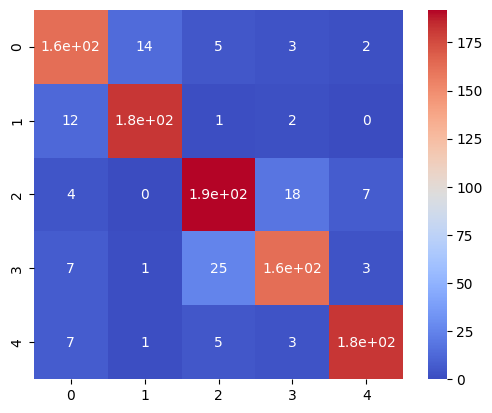

In [16]:
log_reg = LogisticRegression()

classification_model_test(X_train, y_train, X_test, y_test, log_reg)

###Next we'll try models that are a little more complex that can handle non-linear relationships. These models are Decision Tree Classifier and K-Nearest Neighbor Classifier

              precision    recall  f1-score   support

           0       0.51      0.48      0.50       186
           1       0.51      0.51      0.51       197
           2       0.58      0.57      0.58       221
           3       0.47      0.48      0.47       198
           4       0.65      0.68      0.66       198

    accuracy                           0.55      1000
   macro avg       0.54      0.54      0.54      1000
weighted avg       0.55      0.55      0.55      1000



'Accuracy Score: 0.55'

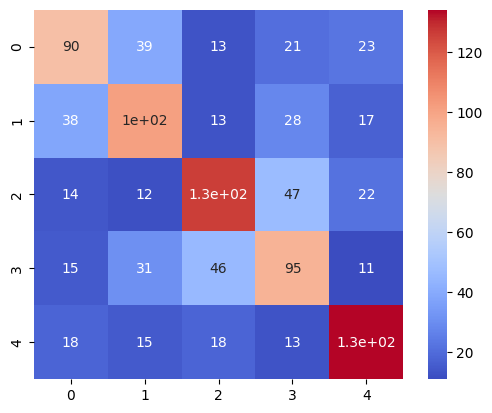

In [17]:
decision_tree = DecisionTreeClassifier()

classification_model_test(X_train, y_train, X_test, y_test, decision_tree)

              precision    recall  f1-score   support

           0       0.27      0.58      0.37       186
           1       0.46      0.79      0.58       197
           2       0.87      0.21      0.34       221
           3       0.56      0.08      0.13       198
           4       0.75      0.69      0.72       198

    accuracy                           0.46      1000
   macro avg       0.58      0.47      0.43      1000
weighted avg       0.59      0.46      0.43      1000



'Accuracy Score: 0.46'

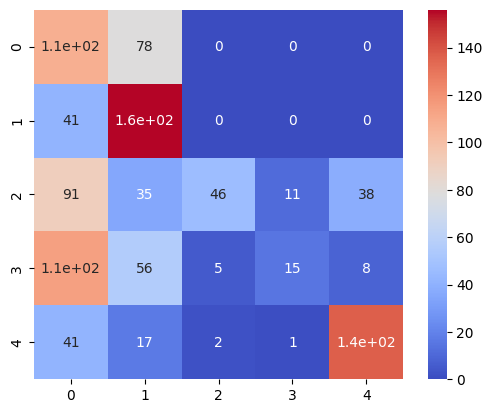

In [18]:
knn = KNeighborsClassifier()

classification_model_test(X_train, y_train, X_test, y_test, knn)

###Now we'll try some ensemble methods to see if the accuracy will improve by using models that naturally combat errors and over/underfitting issues. The models are called Random Forest Classifier and Ada Boost Classifier.

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       186
           1       0.93      0.85      0.89       197
           2       0.82      0.78      0.80       221
           3       0.77      0.83      0.80       198
           4       0.92      0.85      0.89       198

    accuracy                           0.84      1000
   macro avg       0.85      0.84      0.84      1000
weighted avg       0.85      0.84      0.84      1000



'Accuracy Score: 0.84'

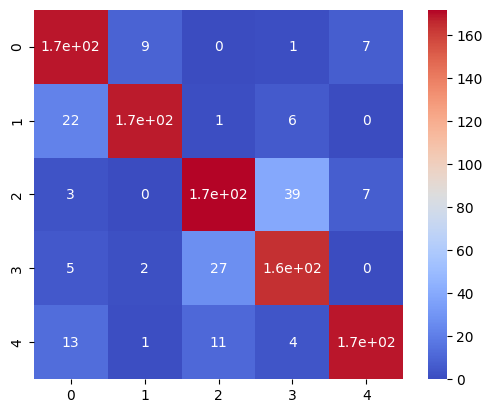

In [19]:
random_forest = RandomForestClassifier()

classification_model_test(X_train, y_train, X_test, y_test, random_forest)

              precision    recall  f1-score   support

           0       0.69      0.77      0.73       186
           1       0.74      0.65      0.69       197
           2       0.55      0.52      0.53       221
           3       0.44      0.56      0.49       198
           4       0.91      0.75      0.83       198

    accuracy                           0.64      1000
   macro avg       0.67      0.65      0.65      1000
weighted avg       0.66      0.64      0.65      1000



'Accuracy Score: 0.64'

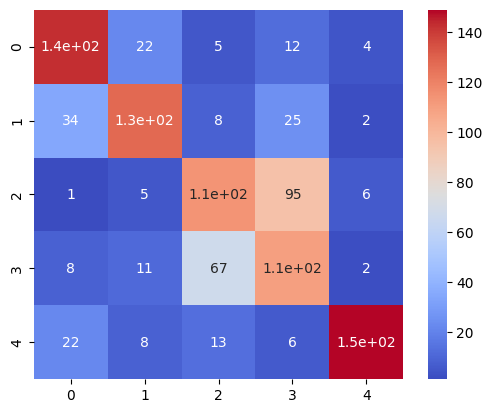

In [20]:
ada = AdaBoostClassifier()

classification_model_test(X_train, y_train, X_test, y_test, ada)

Surprisingly, these classical models actually performed quite well. In particular, the logistic regression model performed at an 88% accuracy. A relatively high level of accuracy for a base model before any hyperparameter tuning.

Some potential reasons as to why logistic regression has performed so well include the nature of HOG features, linearity in feature space, and effective dimensionality reduction. Logistic regression is a linear classifier, which work well with features with approximately linear relationships. Even if the original image isn't linearly seperable, the transformation into HOG features could allow it to work better with logistic regression.

Dimensionality of the feature set is naturally lower than the original 1024 x 1024 image, which can reduce the noise and irrelevant information in the data. HOG captures the important structural information and lowers overall complexity of the data, which is often where a model like logistic regression can thrive.



---



# Deep Learning & Convolutional Neural Network

Now we try the deep learning approach by creating a convolutional neural network (CNN). We will be using a sequential convolutional neural network, which is a CNN where the layers are in a sequential order.

In [7]:
# Sequential Architecture
Sequential = tf.keras.models.Sequential

# CNN Layer States
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout
Flatten = tf.keras.layers.Flatten
Conv2D = tf.keras.layers.Conv2D
MaxPool2D = tf.keras.layers.MaxPool2D

# Optimizer
Adam = tf.keras.optimizers.Adam

# Image Preprocessing Engine
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator

Now that some basic setup has been done, we need to grab our data and set our training, validation, and testing splits.

In [8]:
CLASSES = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

# Define image height and width
image_height = image_width = 256

batch_size = 16

# Create training and validation datasets with a 25% validation split
training_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir,
    label_mode='int',
    class_names=CLASSES,
    validation_split=0.25,
    subset='training',
    seed=88,
    image_size=(image_height, image_width),
    batch_size=batch_size,
)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir,
    label_mode='int',
    class_names=CLASSES,
    validation_split=0.25,
    subset='validation',
    seed=88,
    image_size=(image_height, image_width),
    batch_size=batch_size,
)

# Split validation data into 80% validation and 20% test data
test_data = validation_data.take(validation_data.cardinality() // 5)
validation_data = validation_data.skip(validation_data.cardinality() // 5)

# Show the number of batches in each dataset
print(f'Number of training batches: {training_data.cardinality().numpy()}')
print(f'Number of validation batches: {validation_data.cardinality().numpy()}')
print(f'Number of test batches: {test_data.cardinality().numpy()}')

Found 5000 files belonging to 5 classes.
Using 3750 files for training.
Found 5000 files belonging to 5 classes.
Using 1250 files for validation.
Number of training batches: 235
Number of validation batches: 64
Number of test batches: 15


We need to rescale and normalize our image data since we've only resized it in the previous cell.

In [9]:
# Normalize images to [0, 1] after loading
normalization_layer = tf.keras.layers.Rescaling(1.0/255)

# Apply normalization to datasets
training_data = training_data.map(lambda x, y: (normalization_layer(x), y))
validation_data = validation_data.map(lambda x, y: (normalization_layer(x), y))
test_data = test_data.map(lambda x, y: (normalization_layer(x), y))

After preprocessing, let's set up the CNN arcitecture.

Convolutional Layers:

For a 5,000 image dataset, three convolutional layers should be good enough to capture local and global features. We slowly increase the filter size as we get deeper into the layers. Typically a 3x3 kernel should be enough for most image tasks.

Pooling Layers:

Pooling layers progressively reduces spatial dimensions to increase translational invariance (cells appear in different positions) and control overfitting by discarding exact positional data.

Dropout Layers:

The dropout layer helps overfitting risks from limited data, and also helps counteract class imbalance.

In [10]:
# Three convolutional layers to create feature mapping
convolutional_layer_1 =   Conv2D(filters=16,
                                 kernel_size=(2, 2),
                                 padding="Same",
                                 activation="relu",
                                 input_shape=(256, 256, 3))
convolutional_layer_2 =   Conv2D(filters=32,
                                 kernel_size=(2, 2),
                                 padding="Same",
                                 activation="relu")
convolutional_layer_3 =   Conv2D(filters=64,
                                 kernel_size=(2, 2),
                                 padding="Same",
                                 activation="relu")

# Three corresponding pooling layers to reduce convolved dimensionality
pooling_layer_1 = MaxPool2D(pool_size=(2, 2))
pooling_layer_2 = MaxPool2D(pool_size=(2, 2))
pooling_layer_3 = MaxPool2D(pool_size=(2, 2))

# Two dropout layers: one after convolutions and one after the ANN layer
dropout_layer_1 =         Dropout(0.2)
dropout_layer_2 =         Dropout(0.3)

# A flattening layer for ingestion into the ANN
flattening_layer_1 =      Flatten()

# Two dense layers to make up the significant ANN architecture
connective_layer_1 =      Dense(256,
                                activation="relu")
connective_layer_2 =      Dense(128,
                                activation="relu")
output_layer =            Dense(5,
                                activation="softmax")

In [11]:
# Initialize sequential model schema
model = Sequential()

# Add first convolutional feature mapping process layers
model.add(convolutional_layer_1)
model.add(pooling_layer_1)

# Add second convolutional feature mapping process layers
model.add(convolutional_layer_2)
model.add(pooling_layer_2)
model.add(dropout_layer_1)

# Add second convolutional feature mapping process layers
model.add(convolutional_layer_3)
model.add(pooling_layer_3)
model.add(dropout_layer_2)

# Add image vectorization process layer
model.add(flattening_layer_1)

# Add connective ANN process layers
model.add(connective_layer_1)
model.add(connective_layer_2)
model.add(output_layer)

# Summarize model layering setup
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 16)        │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      16,777,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,821,557 (64.17 MB)

 Trainable params: 16,821,557 (64.17 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Define Adam optimization
optimizer = Adam(learning_rate=0.001)

In [13]:
# Set compilation properties
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set epochs and batch size
epochs, batch_size = 10, 32

In [14]:
history = model.fit(training_data,
    validation_data=validation_data,
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step - accuracy: 0.5339 - loss: 1.3968 - val_accuracy: 0.8238 - val_loss: 0.5445
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.8906 - loss: 0.3180 - val_accuracy: 0.8861 - val_loss: 0.2718
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.9391 - loss: 0.1659 - val_accuracy: 0.9406 - val_loss: 0.1580
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.9477 - loss: 0.1541 - val_accuracy: 0.9545 - val_loss: 0.1510
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.9694 - loss: 0.0828 - val_accuracy: 0.9752 - val_loss: 0.0634
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.9797 - loss: 0.0608 - val_accuracy: 0.9713 - val_loss: 0.0849
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 351s 1s/step - accuracy: 0.9774 - loss: 0.0720 - val_accuracy: 0.9743 - val_loss: 0.0749
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.9799 - loss: 0.0568 - val_accu

In [35]:
def plot_training_results(history):
    # Extract metrics
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    # Find optimal epoch (val_loss minimum or val_acc maximum)
    optimal_epoch_loss = np.argmin(val_loss) + 1  # +1 because epochs start at 1
    optimal_epoch_acc = np.argmax(val_acc) + 1
    optimal_epoch = optimal_epoch_loss  # Or use optimal_epoch_acc if preferred

    plt.figure(figsize=(20, 8))


    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training', linewidth=2)
    plt.plot(epochs_range, val_acc, label='Validation', linewidth=2)

    # Highlight optimal epoch
    plt.axvline(x=optimal_epoch, color='red', linestyle='--', alpha=0.7)
    plt.scatter(optimal_epoch, val_acc[optimal_epoch-1],
                color='red', s=100, label=f'Peak Val Acc: {val_acc[optimal_epoch-1]:.2f}')

    plt.title('Accuracy\nOptimal Epoch: {}'.format(optimal_epoch), fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training', linewidth=2)
    plt.plot(epochs_range, val_loss, label='Validation', linewidth=2)

    # Highlight optimal epoch
    plt.axvline(x=optimal_epoch, color='red', linestyle='--', alpha=0.7)
    plt.scatter(optimal_epoch, val_loss[optimal_epoch-1],
                color='red', s=100, label=f'Lowest Val Loss: {val_loss[optimal_epoch-1]:.4f}')

    plt.title('Loss\nOptimal Epoch: {}'.format(optimal_epoch), fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print metrics at optimal epoch
    print(f"\nOptimal Epoch: {optimal_epoch}")
    print(f"Validation Accuracy: {val_acc[optimal_epoch-1]:.4f}")
    print(f"Validation Loss: {val_loss[optimal_epoch-1]:.4f}")

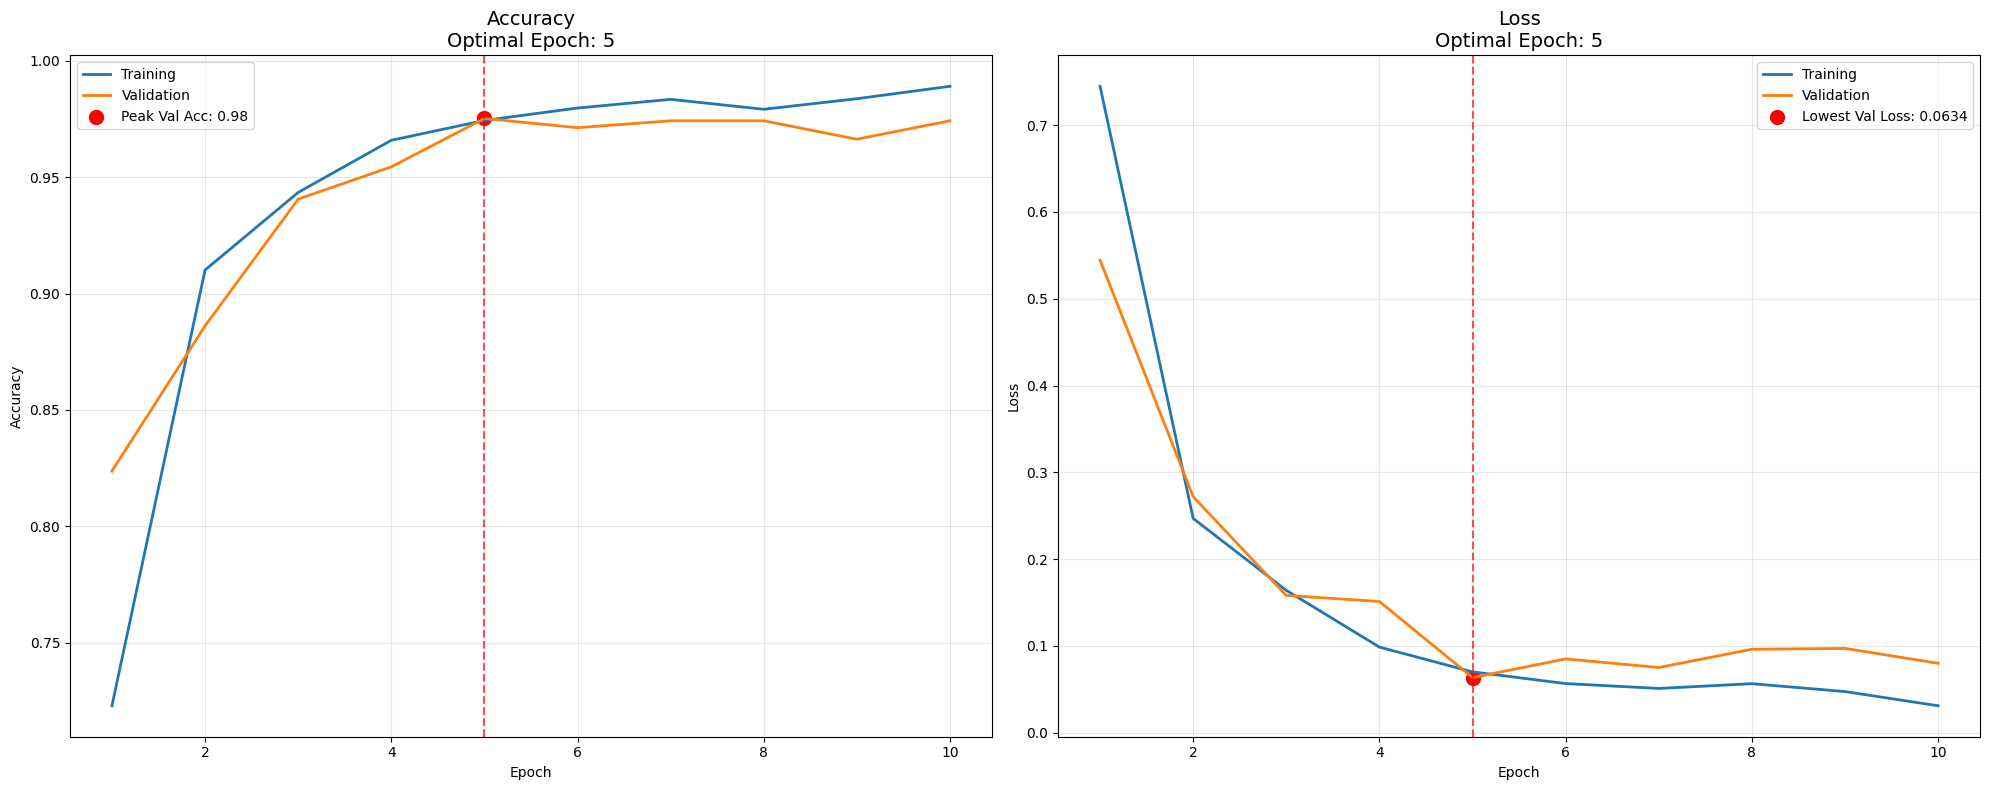


Optimal Epoch: 5
Validation Accuracy: 0.9752
Validation Loss: 0.0634


In [36]:
plot_training_results(history)

In [17]:
# Now that our model is trained, we can run it on the test data to see how it performs.

test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 482ms/step - accuracy: 0.9690 - loss: 0.0812
Test Loss: 0.05908399447798729
Test Accuracy: 0.9791666865348816


# Analysis, Design Choices & Conclusion

The blood cell smear image dataset was more complicated than I had originally expected. With 5,000 images at 1024x1024 resolution each, it can get computationally expensive to run models without sufficient preprocessing. I employed HOG as a technique to help reduce dimensionality of complex images, while not sacrificing any sensitivity to detail. It also gave us tabular data allowing us to fire off classical machine learning models to see how they would perform.

Among the machine learning models used on the HOG feature dataset, the best performing model was logistic regression at 88%! I explained in the machine learning section why I believe the logistic regression model reacted so well to the data. Logistic regression is a simple yet powerful model and is often regarded as a very "simple" form of neural networks. This made me feel confident about applying a neural network to this dataset, more specifically a convolutional neural network.

We were eventually able to create a CNN with 98% accuracy, which was not an easy task. Key architectural decisions were driven by limited RAM and computing power, necessitating careful trade-offs between model complexity and performance. Here is a walk through of my design choices:

1. Image Resizing (1024x1024 → 256x256)


Downsampling preserved critical nuclear contours while drastically reducing memory usage—essential for training on GPU-limited systems. Studies confirm 256px resolution retains diagnostic features for lymphocyte assessment (Prell et al., 2019), making this a computationally efficient compromise. Any larger of a size would deplete the computer's RAM upon running.

2. Convolutional Layers (16/32/64 filters, 2x2 kernels)


A shallow-to-deep filter progression (16 → 32 → 64) minimized initial memory load while gradually capturing complex features.


Small 2×2 kernels were chosen to target subtle nuclear textures (e.g., chromatin patterns) without overburdening VRAM.

3. Max Pooling After Each Conv Layer


Progressive spatial reduction improved translational invariance and prevented memory explosion during feature extraction—a critical adjustment for high-resolution medical images.

4. Dropout Layers (20%/30%)


Empirical tuning of dropout rates mitigated overfitting risks from the modest dataset size (5,000 images), compensating for the inability to train a larger model.

5. Flatten → Dense Layers (256 → 128 units)


The bottleneck architecture forced efficient feature compression, avoiding memory overflow in the transition from convolutional to fully connected layers.

Graphs were then created to display the training and validation accuracy and loss. The graphs show excellent convergence, with training and validation metrics closely aligned throughout all epochs. The validation accuracy (97.4%) nearly matches the training accuracy (98.8%), indicating no significant overfitting. The optimal epoch appears to be around epoch 5, where:

Validation accuracy peaks at 97.5%.

Validation loss reaches its minimum (0.0634).

Beyond this point, while training accuracy continues to improve slightly, validation metrics plateau, suggesting diminishing returns from additional training. The close tracking of training and validation curves demonstrates effective regularization via your dropout layers and appropriate model capacity for this 5-class blood cell classification task. The early high validation accuracy (82.4% in epoch 1) suggests the model quickly learned generalizable features, likely due to the clinically relevant patterns in your 1024x1024→256x256 resized cell images.

Upon running this trained model on the 240 remaining images set aside as test data, the CNN was able to achieve 97.9% accuracy. A very good result considering the data complexity and overall restrictions.

# Appendix

Dataset:

https://www.kaggle.com/datasets/sumithsingh/blood-cell-images-for-cancer-detection/data

HOG Resources:

https://medium.com/@prantiksen4/training-a-neural-network-with-histogram-of-oriented-gradients-hog-features-373b97be5971

https://github.com/pransen/ComputerVisionAlgorithms/blob/master/Histogram%20of%20Oriented%20Gradients%20--%20MNIST/MNIST%20with%20HOG%20Features.ipynb

Logistic Regression:

https://sebastianraschka.com/faq/docs/logisticregr-neuralnet.html

Convolutional Neural Network:

https://colab.research.google.com/drive/1NfjT-LNbQd0YB6dwOS9qqPqikjp1fJ8u?usp=sharing